<a href="https://colab.research.google.com/github/gulabpatel/Knowledge_Distillation/blob/main/3_pytorch_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Calibration
The process of choosing the input clipping range is known as calibration. The simplest technique (also the default in PyTorch) is to record the running mininmum and maximum values and assign them to  and . TensorRT also uses entropy minimization (KL divergence), mean-square-error minimization, or percentiles of the input range.


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
C, L = 3, 4
normal = torch.distributions.normal.Normal(0,1)
inputs = [normal.sample((C, L)), normal.sample((C, L))]
print(inputs)

[tensor([[-0.7263, -1.4862,  0.4027,  0.2487],
        [-0.7735,  0.5579, -0.1400,  0.5003],
        [-0.8770, -1.8155, -0.1084, -0.5743]]), tensor([[-0.7071,  1.5024, -1.3229, -0.8100],
        [ 0.5470,  1.1638, -0.5730, -0.4987],
        [-0.5997, -1.4349,  0.0804,  1.1246]])]


In [5]:
observers = [MinMaxObserver(), MovingAverageMinMaxObserver(), HistogramObserver()]
for obs in observers:
  for x in inputs:
     obs(x) 
  print(obs.__class__.__name__, obs.calculate_qparams())


MinMaxObserver (tensor([0.0130]), tensor([140], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0093]), tensor([194], dtype=torch.int32))
HistogramObserver (tensor([0.0101]), tensor([180], dtype=torch.int32))


## Affine and Symmetric Quantization Schemes

In [6]:
act =  torch.distributions.pareto.Pareto(1, 10).sample((1,1024))
weights = torch.distributions.normal.Normal(0, 0.12).sample((3, 64, 7, 7)).flatten()

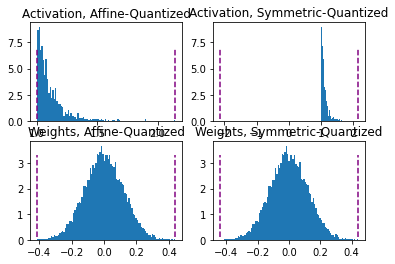

In [10]:
def get_symmetric_range(x):
  beta = torch.max(x.max(), x.min().abs())
  return -beta.item(), beta.item()

def get_affine_range(x):
  return x.min().item(), x.max().item()

def plot(plt, data, scheme):
  boundaries = get_affine_range(data) if scheme == 'affine' else get_symmetric_range(data)
  a, _, _ = plt.hist(data, density=True, bins=100)
  ymin, ymax = np.quantile(a[a>0], [0.25, 0.95])
  plt.vlines(x=boundaries, ls='--', colors='purple', ymin=ymin, ymax=ymax)

fig, axs = plt.subplots(2,2)
plot(axs[0, 0], act, 'affine')
axs[0, 0].set_title("Activation, Affine-Quantized")

plot(axs[0, 1], act, 'symmetric')
axs[0, 1].set_title("Activation, Symmetric-Quantized")

plot(axs[1, 0], weights, 'affine')
axs[1, 0].set_title("Weights, Affine-Quantized")

plot(axs[1, 1], weights, 'symmetric')
axs[1, 1].set_title("Weights, Symmetric-Quantized")
plt.show()

In PyTorch, you can specify affine or symmetric schemes while initializing the Observer. Note that not all observers support both schemes.

In [12]:
for qscheme in [torch.per_tensor_affine, torch.per_tensor_symmetric]:
  obs = MovingAverageMinMaxObserver(qscheme=qscheme)
  for x in inputs: obs(x)
  print(f"Qscheme: {qscheme} | {obs.calculate_qparams()}")

Qscheme: torch.per_tensor_affine | (tensor([0.0093]), tensor([194], dtype=torch.int32))
Qscheme: torch.per_tensor_symmetric | (tensor([0.0142]), tensor([128]))


For weights quantization, symmetric-per-channel quantization provides better accuracies; per-tensor quantization performs poorly, possibly due to high variance in conv weights across channels from batchnorm folding.

In [13]:
from torch.quantization.observer import MovingAveragePerChannelMinMaxObserver
obs = MovingAveragePerChannelMinMaxObserver(ch_axis=0)  # calculate qparams for all `C` channels separately
for x in inputs: 
  obs(x)
print(obs.calculate_qparams())

(tensor([0.0074, 0.0052, 0.0071]), tensor([199, 147, 255], dtype=torch.int32))


In [15]:
my_qconfig = torch.quantization.QConfig(
  activation=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_affine),
  weight=MovingAveragePerChannelMinMaxObserver.with_args(qscheme=torch.qint8)
)
print(my_qconfig)

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_affine){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, qscheme=torch.qint8){})


## Post-Training Dynamic/Weight-only Quantization


Here the model’s weights are pre-quantized; the activations are quantized on-the-fly (“dynamic”) during inference. The simplest of all approaches, it has a one line API call in torch.quantization.quantize_dynamic. Currently only Linear and Recurrent (LSTM, GRU, RNN) layers are supported for dynamic quantization.



In [16]:
import torch
from torch import nn

# toy model
m = nn.Sequential(
  nn.Conv2d(2, 64, (8,)),
  nn.ReLU(),
  nn.Linear(16,10),
  nn.LSTM(10, 10))

m.eval()

## EAGER MODE
from torch.quantization import quantize_dynamic
model_quantized = quantize_dynamic(
    model=m, qconfig_spec={nn.LSTM, nn.Linear}, dtype=torch.qint8, inplace=False
)


In [21]:
## FX MODE
from torch.quantization import quantize_fx
qconfig_dict = {"": torch.quantization.default_dynamic_qconfig}  # An empty key denotes the default applied to all modules
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs=torch.rand(1, 3, 224, 224))
model_quantized = quantize_fx.convert_fx(model_prepared)

##Post-Training Static Quantization (PTQ)

Module fusion combines multiple sequential modules (eg: [Conv2d, BatchNorm, ReLU]) into one. Fusing modules means the compiler needs to only run one kernel instead of many; this speeds things up and improves accuracy by reducing quantization error.

(+) Static quantization has faster inference than dynamic quantization because it eliminates the float<->int conversion costs between layers.

(-) Static quantized models may need regular re-calibration to stay robust against distribution-drift.


In [22]:
import torch
from torch import nn
import copy

backend = "fbgemm"  # running on a x86 CPU. Use "qnnpack" if running on ARM.

model = nn.Sequential(
     nn.Conv2d(2,64,3),
     nn.ReLU(),
     nn.Conv2d(64, 128, 3),
     nn.ReLU()
)

## EAGER MODE
m = copy.deepcopy(model)
m.eval()
"""Fuse
- Inplace fusion replaces the first module in the sequence with the fused module, and the rest with identity modules
"""
torch.quantization.fuse_modules(m, ['0','1'], inplace=True) # fuse first Conv-ReLU pair
torch.quantization.fuse_modules(m, ['2','3'], inplace=True) # fuse second Conv-ReLU pair


Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (1): Identity()
  (2): ConvReLU2d(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (3): Identity()
)

In [28]:
"""Insert stubs"""
m = nn.Sequential(torch.quantization.QuantStub(), 
                  *m, 
                  torch.quantization.DeQuantStub())

"""Prepare"""
m.qconfig = torch.quantization.get_default_qconfig(backend)
torch.quantization.prepare(m, inplace=True)

"""Calibrate
- This example uses random data for convenience. Use representative (validation) data instead.
"""
with torch.inference_mode():
  for _ in range(10):
    x = torch.rand(1,2, 28, 28)
    m(x)
    
"""Convert"""
torch.quantization.convert(m, inplace=True)

"""Check"""
print(m[1].weight().element_size()) # 1 byte instead of 4 bytes for FP32


1


In [26]:
## FX GRAPH
from torch.quantization import quantize_fx
m = copy.deepcopy(model)
m.eval()
qconfig_dict = {"": torch.quantization.get_default_qconfig(backend)}
# Prepare
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict,example_inputs=torch.rand(1, 3, 224, 224))
# Calibrate - Use representative (validation) data.
with torch.inference_mode():
  for _ in range(10):
    x = torch.rand(1,2,28, 28)
    model_prepared(x)
# quantize
model_quantized = quantize_fx.convert_fx(model_prepared)

## Quantization-aware Training (QAT)


In [29]:
import torch
from torch import nn

backend = "fbgemm"  # running on a x86 CPU. Use "qnnpack" if running on ARM.

m = nn.Sequential(
     nn.Conv2d(2,64,8),
     nn.ReLU(),
     nn.Conv2d(64, 128, 8),
     nn.ReLU()
)

"""Fuse"""
torch.quantization.fuse_modules(m, ['0','1'], inplace=True) # fuse first Conv-ReLU pair
torch.quantization.fuse_modules(m, ['2','3'], inplace=True) # fuse second Conv-ReLU pair

"""Insert stubs"""
m = nn.Sequential(torch.quantization.QuantStub(), 
                  *m, 
                  torch.quantization.DeQuantStub())

In [30]:
"""Prepare"""
m.train()
m.qconfig = torch.quantization.get_default_qconfig(backend)
torch.quantization.prepare_qat(m, inplace=True)

Sequential(
  (0): QuantStub(
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (1): ConvReLU2d(
    2, 64, kernel_size=(8, 8), stride=(1, 1)
    (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (2): Identity()
  (3): ConvReLU2d(
    64, 128, kernel_size=(8, 8), stride=(1, 1)
    (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (4): Identity()
  (5): DeQuantStub()
)

In [31]:
"""Training Loop"""
n_epochs = 10
opt = torch.optim.SGD(m.parameters(), lr=0.1)
loss_fn = lambda out, tgt: torch.pow(tgt-out, 2).mean()
for epoch in range(n_epochs):
  x = torch.rand(10,2,24,24)
  out = m(x)
  loss = loss_fn(out, torch.rand_like(out))
  opt.zero_grad()
  loss.backward()
  opt.step()

In [32]:
"""Convert"""
m.eval()
torch.quantization.convert(m, inplace=True)

Sequential(
  (0): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (1): QuantizedConvReLU2d(2, 64, kernel_size=(8, 8), stride=(1, 1), scale=0.012718189507722855, zero_point=0)
  (2): Identity()
  (3): QuantizedConvReLU2d(64, 128, kernel_size=(8, 8), stride=(1, 1), scale=0.00597846694290638, zero_point=0)
  (4): Identity()
  (5): DeQuantize()
)

## SENSITIVITY ANALYSIS

In [34]:
for quantized_layer, _ in model.named_modules():
  print("Only quantizing layer: ", quantized_layer)

  # The module_name key allows module-specific qconfigs. 
  qconfig_dict = {"": None, 
  "module_name":[(quantized_layer, torch.quantization.get_default_qconfig(backend))]}

  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict,example_inputs=torch.rand(1, 3, 224, 224))
  # calibrate
  model_quantized = quantize_fx.convert_fx(model_prepared)
  # evaluate(model)

Only quantizing layer:  
Only quantizing layer:  0
Only quantizing layer:  1
Only quantizing layer:  2
Only quantizing layer:  3


/usr/local/lib/python3.8/dist-packages/torch/ao/quantization/observer.py:1204: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


https://pytorch.org/assets/images/quantization-practice/compare_output_ns.png

In [ ]:
# #extract from https://pytorch.org/tutorials/prototype/numeric_suite_tutorial.html
# import torch.quantization._numeric_suite as ns

# def SQNR(x, y):
#     # Higher is better
#     Ps = torch.norm(x)
#     Pn = torch.norm(x-y)
#     return 20*torch.log10(Ps/Pn)

# wt_compare_dict = ns.compare_weights(fp32_model.state_dict(), int8_model.state_dict())
# for key in wt_compare_dict:
#     print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

# act_compare_dict = ns.compare_model_outputs(fp32_model, int8_model, input_data)
# for key in act_compare_dict:
#     print(key, compute_error(act_compare_dict[key]['float'][0], act_compare_dict[key]['quantized'][0].dequantize()))
